In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# da taset
df = pd.read_csv('/content/drive/MyDrive/NLP (1)/Tweets.csv')

# Dropping the 'textID' column
df.drop(columns=['textID'], inplace=True)

# Function to clean and preprocess text
def clean_and_preprocess_text(text):
    # Convert non-string to string
    text = str(text)
    # Lowercasing the text
    text = text.lower()
    # Removing URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Removing special characters and numbers
    text = re.sub(r'\W+|\d+', ' ', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stop words and stemming
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    filtered_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    # Rejoining the tokens into a string
    return " ".join(filtered_tokens)

# Applying the cleaning function to 'text' and 'selected_text' columns
df['text'] = df['text'].apply(clean_and_preprocess_text)
df['selected_text'] = df['selected_text'].apply(clean_and_preprocess_text)

# Display
print(df.head(2))


                      text selected_text sentiment
0               respond go    respond go   neutral
1  sooo sad miss san diego      sooo sad  negative


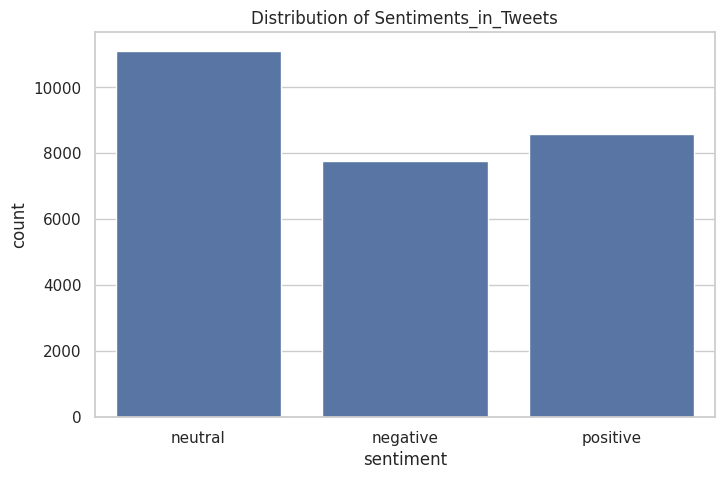

In [ ]:

# Set plot style
sns.set(style="whitegrid")

# Analyzing Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments_in_Tweets')
plt.show()


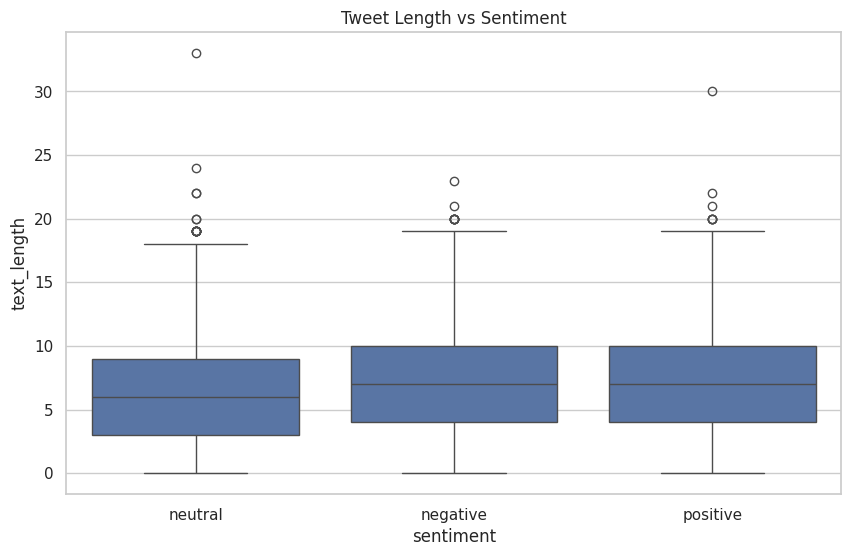

In [ ]:
# Analyzing the Relationship Between Tweet Length and Sentiment
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='text_length', data=df)
plt.title('Tweet Length vs Sentiment')
plt.show()


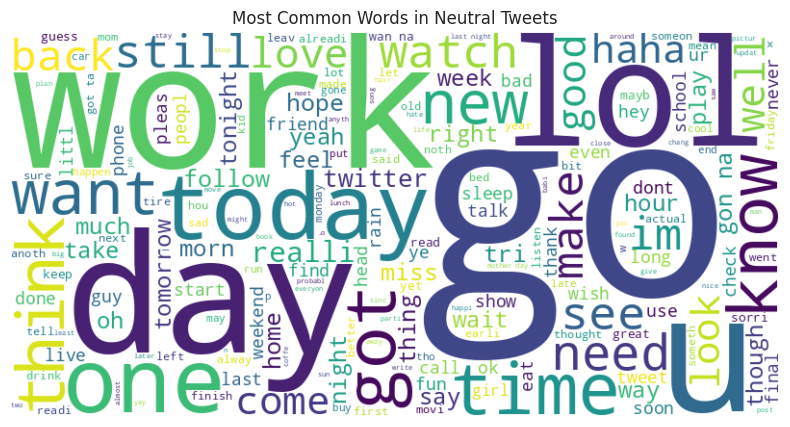

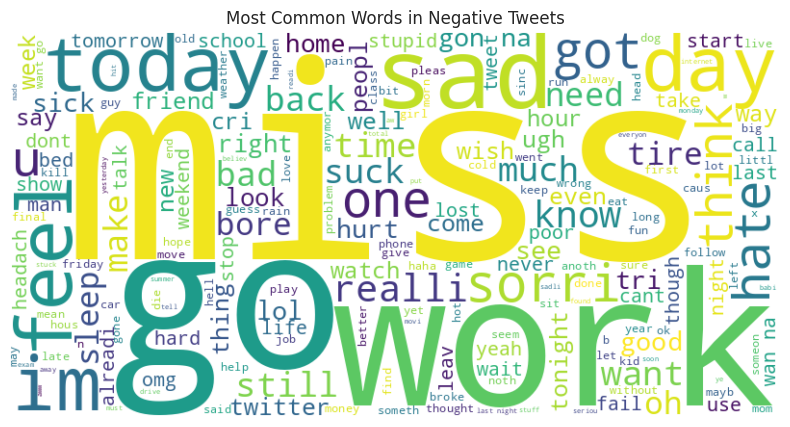

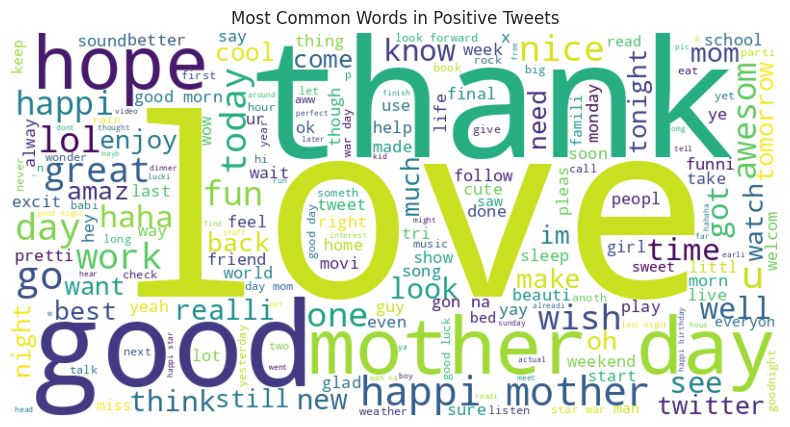

In [ ]:
# Visualizing Common Words in Each Sentiment Category
for sentiment in df['sentiment'].unique():
    subset = df[df['sentiment'] == sentiment]
    text = " ".join(subset['text'].tolist())

    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Common Words in {sentiment.capitalize()} Tweets')
    plt.axis("off")
    plt.show()

In [ ]:
df.columns

Index(['text', 'selected_text', 'sentiment', 'text_length'], dtype='object')

In [ ]:
# begin the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Apply TF-IDF to the 'text' column to have the feature matrix
X_tfidf = tfidf_vectorizer.fit_transform(df['selected_text'])

# Encoding the 'sentiment' column
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['sentiment'])

# create additional features
df['tweet_length'] = df['text'].apply(lambda x: len(x.split()))


#  include 'tweet_length' as a feature:
from scipy.sparse import hstack
X_final = hstack((X_tfidf, df[['tweet_length']].values.astype(float)))
# Actually the model performance fall behind around 10% when use tweet length as a feature so not use it.

In [ ]:
df.head(2)

,text,selected_text,sentiment,text_length,tweet_length
0,respond go,respond go,neutral,2,2
1,sooo sad miss san diego,sooo sad,negative,5,5


In [ ]:
# checking encoding
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)


{'negative': 0, 'neutral': 1, 'positive': 2}


**Classification Models**

In [ ]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tfidf, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the models
logistic_model = LogisticRegression(max_iter=1000)
naive_bayes_model = MultinomialNB()
svm_model = SVC()
#random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Logistic Regression model and evaluate on validation set
logistic_model.fit(X_train, y_train)
logistic_train_preds = logistic_model.predict(X_train)
logistic_val_preds = logistic_model.predict(X_val)
logistic_train_accuracy = accuracy_score(y_train, logistic_train_preds)
logistic_val_accuracy = accuracy_score(y_val, logistic_val_preds)
print("Logistic Regression Training Accuracy:", logistic_train_accuracy)
print("Logistic Regression Validation Accuracy:", logistic_val_accuracy)

# Train the Naive Bayes model and evaluate on validation set
naive_bayes_model.fit(X_train, y_train)
naive_bayes_train_preds = naive_bayes_model.predict(X_train)
naive_bayes_val_preds = naive_bayes_model.predict(X_val)
naive_bayes_train_accuracy = accuracy_score(y_train, naive_bayes_train_preds)
naive_bayes_val_accuracy = accuracy_score(y_val, naive_bayes_val_preds)
print("Naive Bayes Training Accuracy:", naive_bayes_train_accuracy)
print("Naive Bayes Validation Accuracy:", naive_bayes_val_accuracy)

# Train the SVM model and evaluate on validation set
svm_model.fit(X_train, y_train)
svm_train_preds = svm_model.predict(X_train)
svm_val_preds = svm_model.predict(X_val)
svm_train_accuracy = accuracy_score(y_train, svm_train_preds)
svm_val_accuracy = accuracy_score(y_val, svm_val_preds)
print("SVM Training Accuracy:", svm_train_accuracy)
print("SVM Validation Accuracy:", svm_val_accuracy)

# # Train the Random Forest model and evaluate on validation set
# random_forest_model.fit(X_train, y_train)
# random_forest_train_preds = random_forest_model.predict(X_train)
# random_forest_val_preds = random_forest_model.predict(X_val)
# random_forest_train_accuracy = accuracy_score(y_train, random_forest_train_preds)
# random_forest_val_accuracy = accuracy_score(y_val, random_forest_val_preds)
# print("Random Forest Training Accuracy:", random_forest_train_accuracy)
# print("Random Forest Validation Accuracy:", random_forest_val_accuracy)


Logistic Regression Training Accuracy: 0.8572468288625494
Logistic Regression Validation Accuracy: 0.8015526443474041
Naive Bayes Training Accuracy: 0.827199001871491
Naive Bayes Validation Accuracy: 0.7775351770984958
SVM Training Accuracy: 0.9112081513828238
SVM Validation Accuracy: 0.8005822416302766


In [ ]:
svm_pred = svm_model.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score, cohen_kappa_score, matthews_corrcoef

test_acc_svm = accuracy_score(y_test, svm_pred)
print(test_acc_svm)

accuracy = accuracy_score(y_test, svm_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test, svm_pred, average='weighted')
print(f"F1 Score: {f1}")

recall = recall_score(y_test, svm_pred, average='weighted')
print(f"Recall: {recall}")

precision = precision_score(y_test, svm_pred, average='weighted')
print(f"Precision: {precision}")

kappa = cohen_kappa_score(y_test, svm_pred)
print(f"Kappa: {kappa}")

mcc = matthews_corrcoef(y_test, svm_pred)
print(f"MCC: {mcc}")


0.8042687363570216
Accuracy: 0.8042687363570216
F1 Score: 0.8033398636306768
Recall: 0.8042687363570216
Precision: 0.8132361926304598
Kappa: 0.6981225731258167
MCC: 0.7037664998885294


In [ ]:
naive_bayes_probs = naive_bayes_model.predict_proba(X_test)  # Use predict_proba instead of predict
naive_bayes_pred = naive_bayes_model.predict(X_test)

test_acc_nb = accuracy_score(y_test, naive_bayes_pred)
print(test_acc_nb)

accuracy = accuracy_score(y_test, naive_bayes_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test, naive_bayes_pred, average='weighted')
print(f"F1 Score: {f1}")

recall = recall_score(y_test, naive_bayes_pred, average='weighted')
print(f"Recall: {recall}")

precision = precision_score(y_test, naive_bayes_pred, average='weighted')
print(f"Precision: {precision}")

# Use predicted probabilities for roc_auc_score
auc = roc_auc_score(y_test, naive_bayes_probs, multi_class='ovr')
print(f"AUC: {auc}")

kappa = cohen_kappa_score(y_test, naive_bayes_pred)
print(f"Kappa: {kappa}")

mcc = matthews_corrcoef(y_test, naive_bayes_pred)
print(f"MCC: {mcc}")


0.7792869269949066
Accuracy: 0.7792869269949066
F1 Score: 0.7777649383602497
Recall: 0.7792869269949066
Precision: 0.7959814123880663
AUC: 0.9222718962957407
Kappa: 0.6577946698701282
MCC: 0.6674076687056796


In [ ]:
logistic_reg_probs = logistic_model.predict_proba(X_test)
logistic_reg_pred = logistic_model.predict(X_test)
test_acc_lr = accuracy_score(y_test, logistic_reg_pred)
print(test_acc_lr)

accuracy = accuracy_score(y_test,logistic_reg_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test,logistic_reg_pred, average='weighted')
print(f"F1 Score: {f1}")

recall = recall_score(y_test,logistic_reg_pred, average='weighted')
print(f"Recall: {recall}")

precision = precision_score(y_test,logistic_reg_pred, average='weighted')
print(f"Precision: {precision}")

auc = roc_auc_score(y_test,logistic_reg_probs, multi_class='ovr')
print(f"AUC: {auc}")

kappa = cohen_kappa_score(y_test,logistic_reg_pred)
print(f"Kappa: {kappa}")

mcc = matthews_corrcoef(y_test,logistic_reg_pred)
print(f"MCC: {mcc}")

0.8045112781954887
Accuracy: 0.8045112781954887
F1 Score: 0.804463217395333
Recall: 0.8045112781954887
Precision: 0.8082734498847439
AUC: 0.9275819890102256
Kappa: 0.7004581186991101
MCC: 0.7023745408774972


**Confusion Matrix of Models**

Text(0.5, 1.0, 'Confusion Matrix SVM')

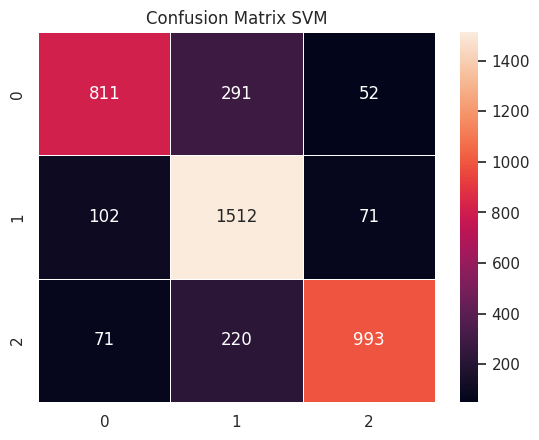

In [ ]:
cfm=confusion_matrix(y_test,svm_pred)
sns.heatmap(cfm,annot=True,fmt='',linewidths=0.5)
plt.title("Confusion Matrix SVM")

Text(0.5, 1.0, 'Confusion Matrix Naive Bayes')

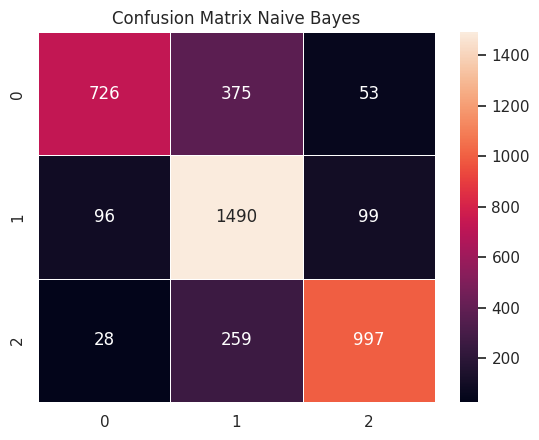

In [ ]:
cfm=confusion_matrix(y_test,naive_bayes_pred)
sns.heatmap(cfm,annot=True,fmt='',linewidths=0.5)
plt.title("Confusion Matrix Naive Bayes")

Text(0.5, 1.0, 'Confusion Matrix Logistic Regression')

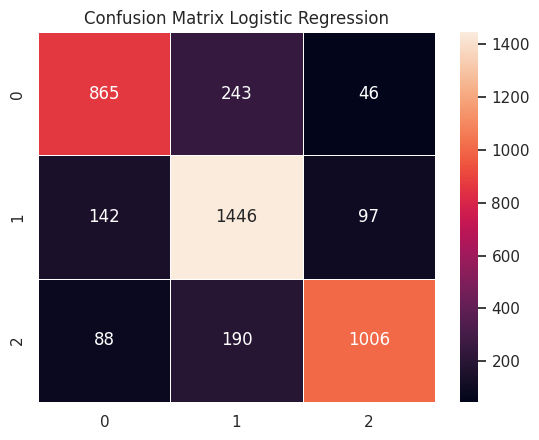

In [ ]:
cfm=confusion_matrix(y_test,logistic_reg_pred)
sns.heatmap(cfm,annot=True,fmt='',linewidths=0.5)
plt.title("Confusion Matrix Logistic Regression")

**Performance Measurement of Models**

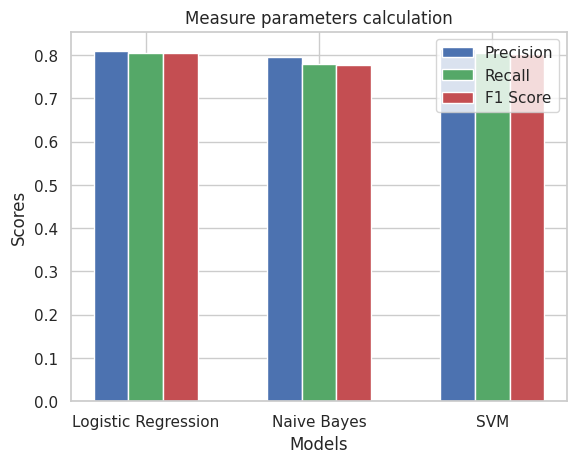

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score


precision_logistic = precision_score(y_test, logistic_reg_pred, average='weighted')
recall_logistic = recall_score(y_test, logistic_reg_pred, average='weighted')
f1_logistic = f1_score(y_test, logistic_reg_pred, average='weighted')

precision_naive_bayes = precision_score(y_test, naive_bayes_pred, average='weighted')
recall_naive_bayes = recall_score(y_test, naive_bayes_pred, average='weighted')
f1_naive_bayes = f1_score(y_test, naive_bayes_pred, average='weighted')

precision_svm = precision_score(y_test, svm_pred, average='weighted')
recall_svm = recall_score(y_test, svm_pred, average='weighted')
f1_svm = f1_score(y_test, svm_pred, average='weighted')


models = ['Logistic Regression', 'Naive Bayes', 'SVM']


precision_scores = [precision_logistic, precision_naive_bayes, precision_svm]
recall_scores = [recall_logistic, recall_naive_bayes, recall_svm]
f1_scores = [f1_logistic, f1_naive_bayes, f1_svm]


bar_width = 0.2


index = np.arange(len(models))


plt.bar(index, precision_scores, bar_width, label='Precision', color='b', align='center')
plt.bar(index + bar_width, recall_scores, bar_width, label='Recall', color='g', align='center')
plt.bar(index + 2 * bar_width, f1_scores, bar_width, label='F1 Score', color='r', align='center')


plt.xlabel('Models')
plt.xticks(index + bar_width, models)


plt.ylabel('Scores')
plt.legend()


plt.title('Measure parameters calculation')
plt.show()
